# Stack Overflow

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

In [8]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

## create the engine

In [9]:
engine = create_engine(connection_string) 

A sample of database

`sample_df`

In [10]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Task 1

Print the total sum of post views for each month of 2008. If there is no data for any month in the database, this month can be skipped. Sort the result in descending order of the total number of views.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [11]:

query = '''

SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS month_date,
    SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY month_date
ORDER BY total_views DESC;

'''
df = pd.read_sql_query(query, con=engine) 
df


,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Conclusion:**

The largest number of views falls on September, October and November, while the summer months have the smallest number of views. I think this is connected precisely with the time of year: in the fall everyone returns to work / study, and in the summer they have a rest and do not spend much time at work.

# Task 2

Print the names of the most active users who gave more than 100 responses in the first month after registration (including the day of registration). Questions asked by users, do not count. For each username, print the number of unique `user_id` values. Sort the result by the field with the names in lexicographic order.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [12]:
# напишите запрос
query = '''

SELECT u.display_name AS display_name,
       COUNT(DISTINCT p.user_id) AS count 
FROM stackoverflow.users AS u
INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id
INNER JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE pt.type = 'Answer' AND
      (DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date)
      AND DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month')
GROUP BY 1
HAVING COUNT(pt.type) > 100
ORDER BY u.display_name;
'''

df1 = pd.read_sql_query(query, con=engine) 
df1

# выполните запрос

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


In [13]:
df1['count'].unique()

array([ 1,  8, 15, 29, 10, 21, 12,  7,  9, 16,  5, 11, 17,  3, 19])

In [14]:
df1[df1['count'] == 29]

,display_name,count
10,Chris,29
45,Matt,29


I want to note that many use the same usernames use many users. For example, the usernames `Chris` and `Matt` are used by at least 29 users. It's not particularly convenient.

# Task 3

Print the number of posts for 2008 by month. Select posts from users who signed up in September 2008 and made at least one post in December of that year. Sort the table by month value in descending order.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [15]:
query = '''

SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN
    (SELECT DISTINCT u.id
     FROM stackoverflow.users u
     JOIN stackoverflow.posts p ON u.id = p.user_id
     WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01'
       AND DATE_TRUNC('month', p.creation_date) = '2008-12-01')
GROUP BY month
ORDER BY month DESC;

'''
df2 = pd.read_sql_query(query, con=engine) 
df2



,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Since we're looking at data about users who signed up in September 2008, it seems rather strange that some of them managed to write a post as early as August of that year. Perhaps the reason is that users first wrote a post and then registered, and the system automatically added this post to this user.

# Task 4

Using the post data, output a few fields:

- ID of the user who wrote the post;
- date of creation of the post;
- the number of views of the current post;
- the amount of views of the author's posts with accumulation.

The data in the table should be sorted in ascending order of user IDs, and the data for the same user should be sorted in ascending order of the date the post was created.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [17]:
query = '''

SELECT user_id,
creation_date,
views_count,
SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date;

'''
df3 = pd.read_sql_query(query, con=engine) 
df3


,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Task 5

Find the average number of user posts per day for August 2008. Select data about users who published more than 120 posts in August. Do not count days without posting.


| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [18]:
query = '''
WITH temp_table AS
  (SELECT user_id,
          DATE_TRUNC('day', creation_date) AS day,
          COUNT(DATE_TRUNC('day', creation_date)) AS posts_count
   FROM stackoverflow.posts
   WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01'
     AND DATE_TRUNC('day', creation_date) <= '2008-08-31'
     AND user_id IN
       (SELECT user_id
        FROM stackoverflow.posts   
        WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01'
          AND DATE_TRUNC('day', creation_date) <= '2008-08-31'
        GROUP BY user_id
        HAVING COUNT(user_id) > 120)
   GROUP BY user_id,
            DAY)
SELECT user_id,
       AVG(posts_count) AS avg_daily
FROM temp_table
GROUP BY user_id
ORDER BY avg_daily;

'''
df4 = pd.read_sql_query(query, con=engine) 
df4


,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Task 6

On average, how many days between 1 December 2008 and 7 December 2008 did users interact with the platform? For each user, select the days on which he or she posted at least one post.

| result |
| -----  |
| <'one number'> |

In [19]:
query = '''

SELECT CAST(AVG(frequency) AS INT) AS result
FROM (
    SELECT COUNT(DISTINCT CAST(creation_date AS DATE)) AS frequency
    FROM stackoverflow.posts
    WHERE creation_date BETWEEN '2008-12-01' AND '2008-12-08'
    GROUP BY user_id
) AS f

'''
df5 = pd.read_sql_query(query, con=engine) 
df5


,result
0,2


On average, during the week, users interact with the platform for 2 days. This is a good result, which means that users use the platform often. Probably on other days, users read other people's posts, write comments.

# Task 7

Display the activity history of each user in this form: user ID, post publication date. Sort the output by ascending user ID, and for each user by ascending publication date.

Add a new field to the table: for each post, it will contain the name of the month of the user's penultimate publication relative to the current one. If there is no such publication, specify `NULL`. Python will automatically change `NULL` to `None`, but you don't need to convert `None` values additionally.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [20]:
query = '''

SELECT user_id,
creation_date, 
CASE EXTRACT(MONTH FROM CAST((lag(creation_date, 2, NULL) over (ORDER BY user_id, creation_date)) AS DATE))
    WHEN 1.0 THEN 'January'
    WHEN 2.0 THEN 'February'
    WHEN 3.0 THEN 'March'
    WHEN 4.0 THEN 'April'
    WHEN 5.0 THEN 'May'
    WHEN 6.0 THEN 'June'
    WHEN 7.0 THEN 'July'
    WHEN 8.0 THEN 'August'
    WHEN 9.0 THEN 'September'
    WHEN 10.0 THEN 'October'
    WHEN 11.0 THEN 'November'
    WHEN 12.0 THEN 'December' 
END
FROM stackoverflow.posts
ORDER BY user_id, creation_date

'''
df6 = pd.read_sql_query(query, con=engine) 
df6


,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Task 8

Calculate the Retention Rate analog by month for StackOverflow users. Organize users into cohorts based on the month of their first post. Return is determined by the presence of a post in the current month.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [21]:
query = '''

WITH profile AS
  (
    SELECT user_id,
    MIN(DATE_TRUNC('month', creation_date)) AS entry_date,
    COUNT(*) OVER (PARTITION BY MIN(EXTRACT(MONTH FROM CAST(creation_date as DATE)))) AS cohort_users_cnt
    FROM stackoverflow.posts
    GROUP BY user_id
   ),
    sessions AS 
    (
        SELECT distinct user_id, DATE_TRUNC('month', creation_date) as month
        FROM stackoverflow.posts
    )
SELECT p.entry_date cohort_dt,
       s.month session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;


'''

df7 = pd.read_sql_query(query, con=engine) 
df7


,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Build a Retention Rate heatmap. What anomalies or other unusual phenomena have been identified? Formulate hypotheses about possible causes.

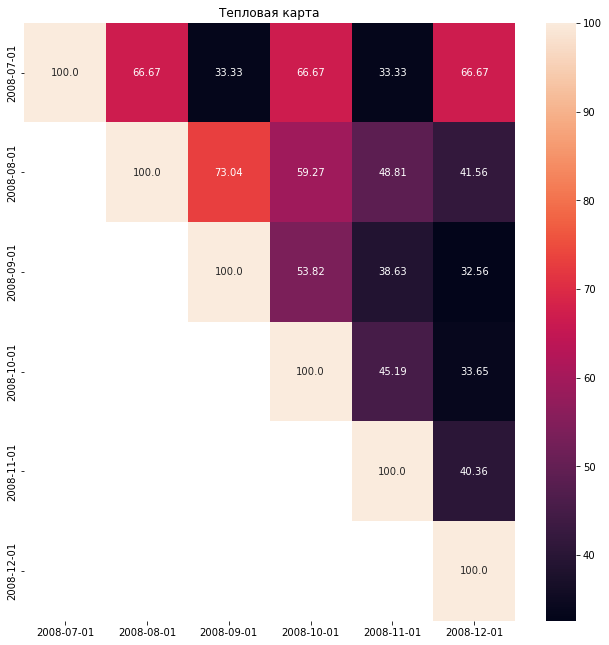

In [22]:
import seaborn as sns


retention = df7.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]


plt.figure(figsize=(11, 11)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show()

The July cohort is very unusual, in which the values ​​in each of the following months alternate rather strangely, as if the data had gone astray. It would be good to double check. The best-performing cohort in August. It is rather strange that for each next cohort, the `retention rate` for the second month is decreasing and decreasing.

# Task 9


By what percent did the number of posts change monthly from September 1 to December 31, 2008? Display a table with the following fields:

- month number;
- the number of posts per month;
- a percentage that shows how much the number of posts in the current month has changed compared to the previous one.

If there are fewer posts, the percentage value should be negative, if there are more, positive. Round the percentage value to two decimal places.


| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [23]:
query = '''

WITH months AS
    (SELECT EXTRACT(MONTH FROM CAST(creation_date AS DATE)) AS month, COUNT(id)
    FROM stackoverflow.posts
    WHERE creation_date BETWEEN '2008-09-01' AND '2009-01-01'
    GROUP BY month)
SELECT CAST(month AS int),
count,
ROUND(CAST((count - lag(count) OVER (ORDER BY month)) AS numeric) / cast(lag(count) OVER (ORDER BY month) AS numeric) * 100, 2) AS change_percent
FROM months 
ORDER BY month

'''
df8 = pd.read_sql_query(query, con=engine) 

df8


,month,count,change_percent
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


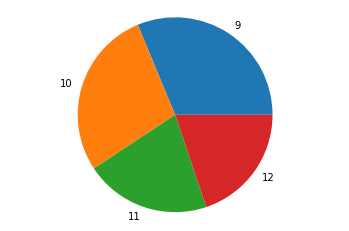

In [24]:
fig1, ax1 = plt.subplots()
ax1.pie(df8['count'], labels=df8['month'])
ax1.axis('equal')  
plt.show()

# Task 10

Download the activity data of the user who posted the most posts of all time. Output the data for October 2008 like this:

- week number;
- date and time of the last post published this week.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [25]:
query = '''

SELECT EXTRACT(WEEK FROM CAST(creation_date AS DATE)) AS week,
MAX(creation_date)
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-10-01' AND '2008-11-01' AND user_id = 
    (SELECT user_id
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT(id) DESC
    limit 1)
GROUP BY week

'''
df9 = pd.read_sql_query(query, con=engine) 
df9


,week,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
